In [13]:
%%capture
!pip install pennylane

In [1]:
import numpy as np
import cvxpy as cp
import scipy as sc
import time
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import json

### 10 qubits

In [90]:
qubits = 10
num_wires = qubits * 2
num_layers = 3
N = 2 ** qubits
seed = 42
num_shots = 1000

def claculate_entropy(rho):
    sigma = np.eye(N) / N
    np.seterr(divide='ignore', invalid='ignore')
    H_rho = np.real(np.trace(rho @ (sc.linalg.logm(rho) - sc.linalg.logm(sigma))))
    np.seterr(divide = 'warn', invalid='warn')
    return H_rho

def generate_random_circuit_structure(qubits, ratio_imprim=0.8, pauli_gates=['PauliX', 'PauliY', 'PauliZ'], seed=None):
    if seed:
        np.random.seed(seed)

    obj_wires = range(qubits)
    num_qubits = len(obj_wires) * 2
    rng = np.random.default_rng(seed)

    num_gates = len(obj_wires) * len(pauli_gates)

    random_values = rng.random(3 * num_gates)
    random_choices = random_values[:num_gates] 
    gate_indices = (random_values[num_gates:2 * num_gates] * len(pauli_gates)).astype(int)
    wire_indices = (random_values[2 * num_gates:3 * num_gates] * len(obj_wires)).astype(int)
    cnot_wires = rng.choice(list(np.arange(num_qubits)), size=(num_gates, 2), replace=True)

    gate_choices = [pauli_gates[i] for i in gate_indices]
    wire_choices = [obj_wires[i] for i in wire_indices]

    circuit_structure = []

    for i in range(num_gates):
        if random_choices[i] < ratio_imprim:
            circuit_structure.append({"gate": "CNOT", "wires": list(cnot_wires[i])})
        else:
            circuit_structure.append({"gate": gate_choices[i], "wires": [wire_choices[i]]})
    
    return circuit_structure

def save_circuit_structure_to_json(circuit_structure, filename):
    def convert_types(obj):
        if isinstance(obj, np.int32):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # 配列はリストに変換
        return obj

    with open(filename, 'w') as f:
        json.dump(circuit_structure, f, default=convert_types)

def load_circuit_structure_from_json(filename):
    with open(filename, 'r') as f:
        circuit_structure = json.load(f)
    return circuit_structure

In [91]:
save_circuit_structure_to_json(generate_random_circuit_structure(qubits), './circuit_structure.json')

In [105]:
device = qml.device("default.qubit", wires=num_wires)
density_matrix = np.zeros((N, N), dtype=np.complex128)

"""
@qml.qnode(device)
def measure_rho(param, circuit_structure, qubits, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(qubits)   

    qml.Hadamard(wires=0)

    for gate_info in circuit_structure:
        gate = gate_info["gate"]
        wires = gate_info["wires"]
        if gate == "CNOT":
            qml.CNOT(wires=wires)
        elif gate == "PauliX":
            qml.PauliX(wires=wires[0])
        elif gate == "PauliY":
            qml.PauliY(wires=wires[0])
        elif gate == "PauliZ":
            qml.PauliZ(wires=wires[0])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = qml.density_matrix(wires=obj_wires)
    return result
"""
@qml.qnode(device)
def measure_rho(param, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(10)   

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 10])
    qml.CNOT(wires=[9, 11])
    qml.CNOT(wires=[6, 1])
    qml.CNOT(wires=[1, 7])
    qml.PauliX(wires=3)
    qml.CNOT(wires=[2, 6])
    qml.CNOT(wires=[3, 5])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)
    result = qml.density_matrix(wires=obj_wires)
    return result

param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# circuit_structure = generate_random_circuit_structure(qubits, seed=seed)
circuit_structure = load_circuit_structure_from_json('./circuit_structure.json')
density_matrix = measure_rho(param_init)
print(f"entropy: {claculate_entropy(density_matrix)}")

entropy: 6.9314718055994495


(<Figure size 2100x1700 with 1 Axes>, <Axes: >)

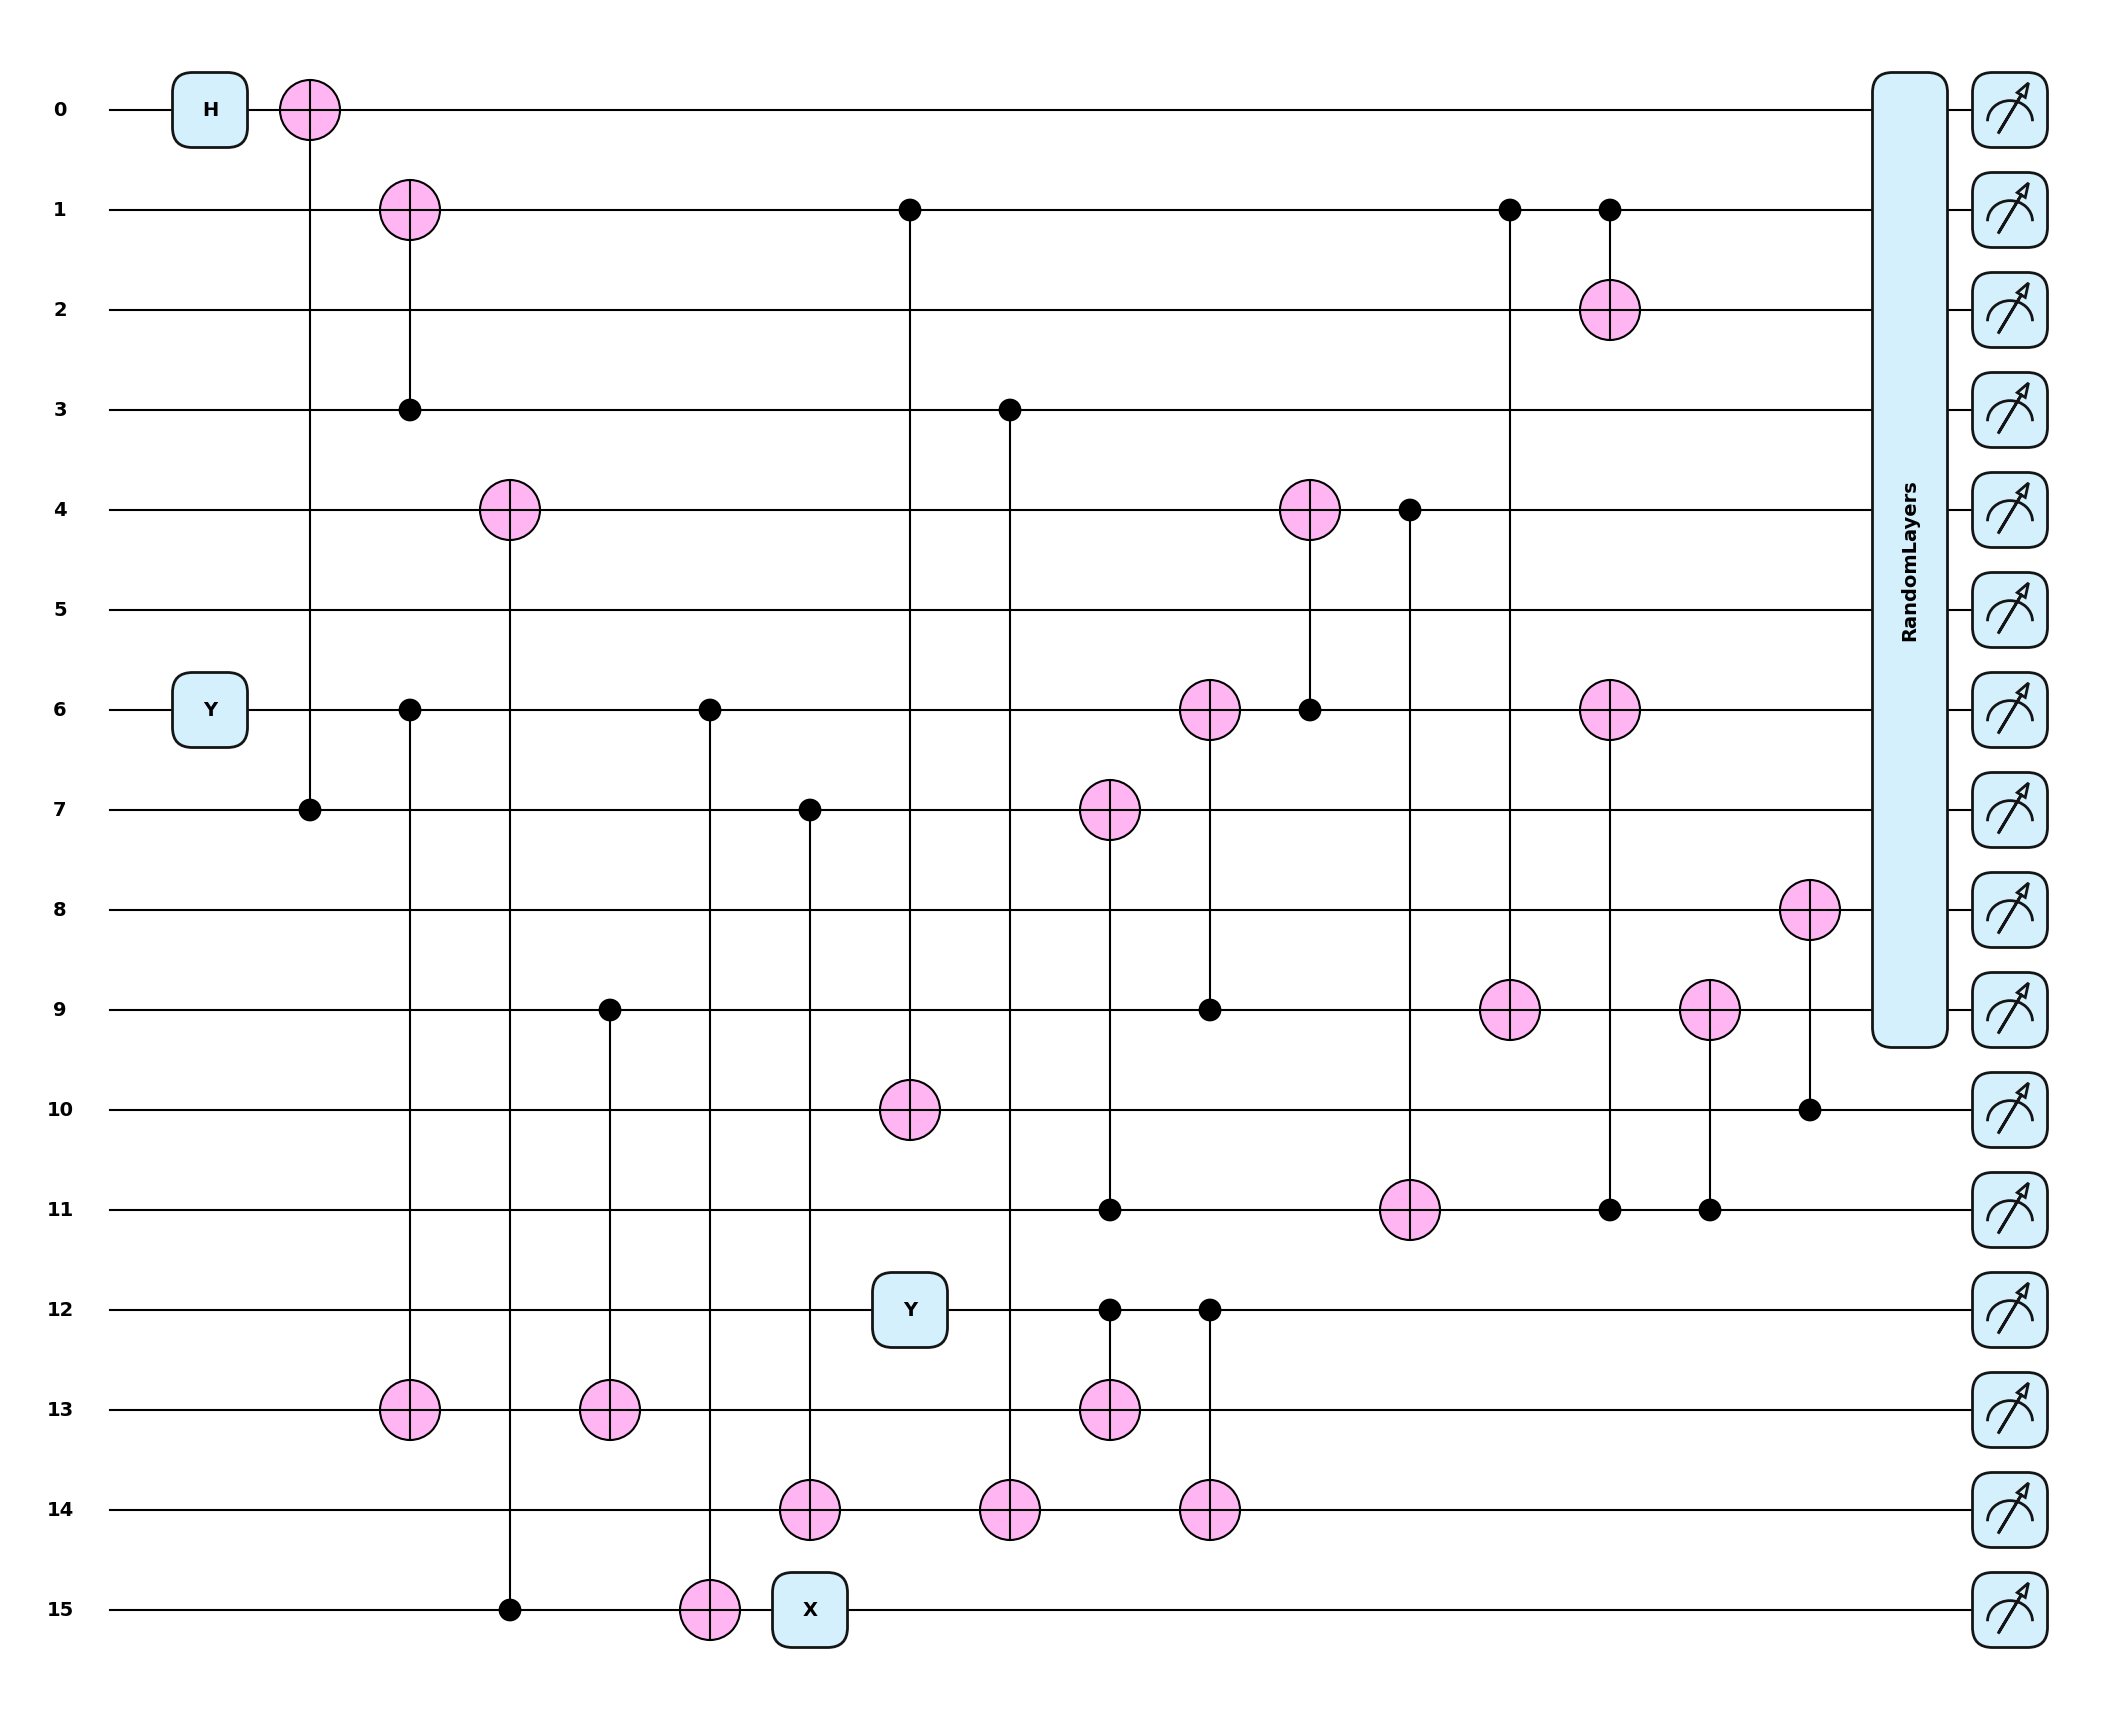

In [93]:
device = qml.device("default.qubit", wires=num_wires, shots=num_shots)
@qml.qnode(device)
def measure_rho(param, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(10)   

    qml.Hadamard(wires=0)
    qml.PauliY(wires=6)
    qml.CNOT(wires=[7, 0])
    qml.CNOT(wires=[6, 13])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = qml.state()
    return result

qml.drawer.use_style("pennylane")
qml.draw_mpl(measure_rho)(param_init)

In [96]:
device = qml.device("default.qubit", wires=num_wires, shots=num_shots)
@qml.qnode(device)
def measure_rho(param, circuit_structure, qubits, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(qubits)   

    qml.Hadamard(wires=0)

    for gate_info in circuit_structure:
        gate = gate_info["gate"]
        wires = gate_info["wires"]
        if gate == "CNOT":
            qml.CNOT(wires=wires)
        elif gate == "PauliX":
            qml.PauliX(wires=wires[0])
        elif gate == "PauliY":
            qml.PauliY(wires=wires[0])
        elif gate == "PauliZ":
            qml.PauliZ(wires=wires[0])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = [qml.sample(qml.PauliZ(i)) for i in range(len(obj_wires))]
    return result

print(f"pauliz measurement: {measure_rho(param_init, circuit_structure, qubits)}")

pauliz measurement: [array([-1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
       -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,
       -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,
       -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  

In [94]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [97]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 100
dimension = qubits
hidden_layer = 20
np.random.seed(42)
batch_size = 100
 
# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):
    
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted, circuit_structure, qubits)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[q][sample] for q in range(dimension)])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted, circuit_structure, qubits)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[q][sample] for q in range(dimension)])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

    
    # save the gradients
    if epoch % 10 == 0:        
      np.save(f"./vn_net_gradients/qubits{qubits}/gradients_epoch{epoch}.npy", gradients)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

    
  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        random_result_array = np.random.choice([-1, 1], size=dimension)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    optimizer.step()
    """

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_rho(prev_param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2
    """
  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=dimension)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(f"Epoch {epoch} Cost: {np.log(N) - first_term + second_term - 1}")

Epoch 1Cost: 6.95831790137005
Epoch 2Cost: 6.933133662667991


KeyboardInterrupt: 

In [98]:
first_term - second_term

-1.0016618570685387

In [99]:
print(sample_nn_result)
print(random_nn_result)

tensor([0.0126], grad_fn=<ViewBackward0>)
tensor([-0.0427], grad_fn=<ViewBackward0>)


In [101]:
neural_fn.state_dict()

OrderedDict([('lin1.weight',
              tensor([[ 0.2216, -0.0840, -0.2960, -0.2226,  0.2264,  0.0975,  0.1463, -0.0785,
                        0.2906, -0.0572],
                      [ 0.2002,  0.2927, -0.3029, -0.0606, -0.0652, -0.0094,  0.1093,  0.1360,
                       -0.2170, -0.2524],
                      [-0.2841,  0.1965,  0.1649, -0.2050, -0.2432, -0.2497, -0.0016, -0.0052,
                        0.2782, -0.1737],
                      [-0.0194, -0.0922,  0.1358,  0.1588,  0.1581,  0.1763,  0.1063, -0.2679,
                        0.2151,  0.0961],
                      [ 0.2155, -0.0496, -0.1689,  0.2522, -0.2299, -0.2788, -0.0497, -0.2035,
                       -0.2371, -0.1239],
                      [-0.1158, -0.2535,  0.2205, -0.3158, -0.2284, -0.2028,  0.0920,  0.0893,
                       -0.1468, -0.1207],
                      [-0.1796, -0.2989,  0.1685,  0.1969, -0.2189,  0.1163,  0.2608,  0.2071,
                        0.1381,  0.2436],
            

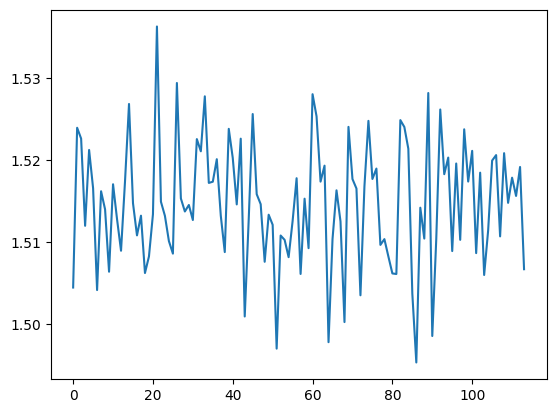

In [75]:
plt.plot(cost_func_store)

memory errorの発生対策でpure stateで回そうね、qubit(wire)数は2~16で頑張ろう

In [28]:
gradients

array([[-0.33101554, -0.1413183 ,  0.00212613],
       [ 0.03686944, -0.11705943, -0.08035086],
       [ 0.01205263,  0.06075445, -0.01458896],
       [ 0.26671589, -0.11148434, -0.00094495],
       [ 0.00047247,  0.30267626,  0.0319795 ],
       [ 0.06693137,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])